In [16]:
import numpy as np
import os, sys, glob, abc
%matplotlib inline
from matplotlib import pyplot as plt, colors
def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

# Where is the dataset stored?
dataset = "/data/i3store/users/mjlarson/student_data"

# Read in all of the data files
data_files = dataset + "/IC86_*exp.npy"
data = read(glob.glob(data_files))

# Read in all of the MC files 
sim_files = dataset + "/IC86*MC*npy"
sim = read(glob.glob(sim_files))

# Set the angular error floor to 0.2 degrees
data['angErr'][data['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
sim['angErr'][sim['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)

data['ra']=np.random.uniform(0,2*np.pi,size=len(data))

In [17]:
import mla.core
from mla.spectral import *
import threeML
#sp= PowerLaw(1,1e-15,2)
sp=threeML.Powerlaw()


In [18]:
from mla.spectral import *
from mla import injection
sp= PowerLaw(1,1e-15,2)
dec = 22.0145*np.pi/180
ra = 83.63*np.pi/180
inj = injection.PSinjector(sp,sim)
inj.set_source_location(ra,dec)
sample=inj.sample_nevents(15)
background = np.random.choice(data, 30).copy()
background['time']=0.5

In [19]:
sample['dec']*180/np.pi

array([22.60216224, 21.85796821, 22.1711825 , 21.82761912, 21.0668248 ,
       23.21402946, 23.0679195 , 22.20929273, 21.93626817, 21.55354281,
       22.7615209 , 22.21685298, 21.72621015, 21.8263582 , 22.80440282])

In [20]:
import numpy.lib.recfunctions as rf
sample = rf.drop_fields(sample, [n for n in sample.dtype.names \
     if not n in background.dtype.names])
injected = np.concatenate([background,sample])
np.save("testdata.npy",injected)

In [21]:
from imp import reload
import scipy.optimize
reload(mla.core)
#sp.K=1e-8
#sp.index=-2
sp= PowerLaw(1,1e-15,2)
testdata=np.load("testdata.npy")
import warnings
warnings.filterwarnings("ignore")
test=mla.core.LLH_point_source(np.radians(83.63) ,np.radians(22.0145) , data , sim , 300 , sp)
test.update_data(testdata,1000/3600/24)
#test.add_injection(sample)


In [22]:
def fit(ns):
    return -test.eval_llh_ns(ns)[1]
result=scipy.optimize.minimize(fit,5,bounds=[(0,test.N)])

In [23]:
result

      fun: -274.6854319650063
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.68434189e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 7
   status: 0
  success: True
        x: array([14.99896959])

In [24]:
x=np.linspace(0,test.N,100)
temp=[]
ns_true = (testdata['run']>200000).sum()
for i in x:
    temp.append(fit(i))

Text(0.5, 1.0, 'Result from mla')

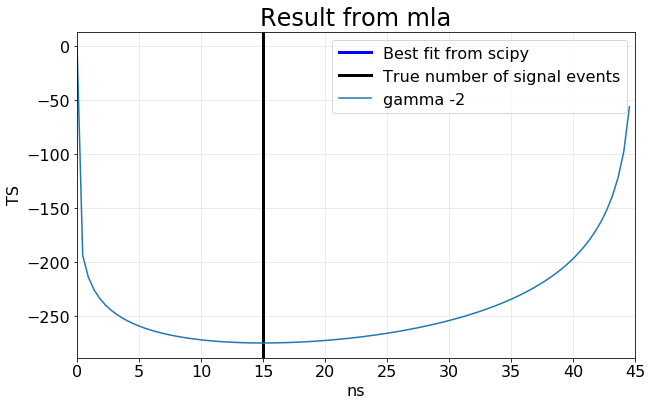

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt, colors
fig, ax = plt.subplots(figsize=(10,6))
ax.axvline(result.x,
            color='b',
           linewidth=3,
            label = 'Best fit from scipy')
ax.axvline(ns_true,
            color='k',
           linewidth=3,
            label = 'True number of signal events')
ax.plot(x,temp,label = 'gamma '+str(-2))
ax.grid(alpha=0.3)
ax.set_xlim(0, len(testdata))
ax.legend(fontsize=16,)
ax.set_xlabel("ns", fontsize=16)
ax.set_ylabel("TS", fontsize=16)
ax.tick_params(which='both', labelsize=16)
ax.set_title("Result from mla", fontsize=24)

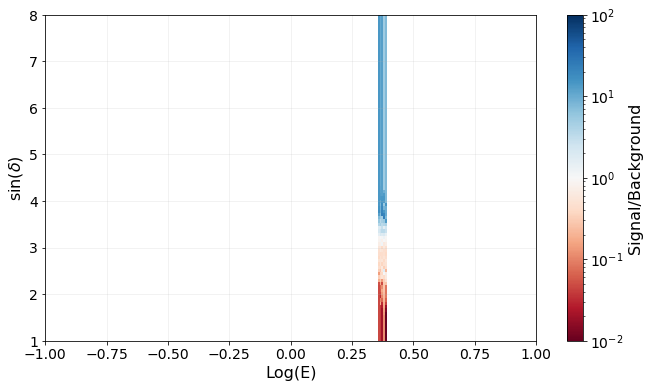

In [26]:
bins = np.array([np.linspace(-1, 1, 300), # bins for sin(dec)
                 np.linspace(1, 8, 100)]) # bins for logE


# And draw it.
fig, ax = plt.subplots(figsize=(11,6))
cmesh = ax.pcolormesh(bins[0], bins[1],
                      test.ratio.T,
                      cmap = 'RdBu',
                      norm=colors.LogNorm(),
                      vmin=1e-2,
                      vmax=1e2)
cbar = plt.colorbar(cmesh, ax=ax)

ax.grid(alpha=0.2)
ax.set_xlabel("Log(E)", fontsize=16)
ax.set_ylabel(r"sin($\delta$)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)

In [ ]:
bins = np.array([np.linspace(-1, 1, 300), # bins for sin(dec)
                 np.linspace(1, 8, 100)]) # bins for logE
temp=np.copy(test.ratio)
for i in range(len(bins[0])-1):
    for j in range(len(bins[1])-1):
        if i < test.edge_point[0]:
            k = test.edge_point[0]
        elif i > test.edge_point[1]:
            k = test.edge_point[1]
        else:
            k = i
        temp[i][j]=test.ratio[k][j]
# And draw it.


In [ ]:
fig, ax = plt.subplots(figsize=(11,6))
cmesh = ax.pcolormesh(bins[0], bins[1],
                      temp.T,
                      cmap = 'RdBu',
                      norm=colors.LogNorm(),
                      vmin=1e-2,
                      vmax=1e2)
cbar = plt.colorbar(cmesh, ax=ax)

ax.grid(alpha=0.2)
ax.set_xlabel("Log(E)", fontsize=16)
ax.set_ylabel(r"sin($\delta$)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)

In [29]:
test.edge_point[0]

203

In [30]:
test.edge_point[1]

207